# Your first CNN on CIFAR-10

In this task you will: 
* define your first CNN architecture for CIFAR-10 dataset
* train it from scratch
* visualize learnt filters

CIFAR-10 dataset contains 32x32 color images from 10 classes: __airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck__:
<img src="cifar10.jpg" style="width:80%">

# Import stuff

In [52]:
!pip install keras
!pip install keras-tqdm

In [53]:
import tensorflow as tf
import keras
from keras import backend as K
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
print(tf.__version__)
print(keras.__version__)
from keras_tqdm import TQDMNotebookCallback

1.4.0
2.1.2


# Load dataset

In [85]:
from cifar import load_cifar10
x_train,y_train,x_val,y_val,x_test,y_test = load_cifar10("cifar_data",channels_last=True)

NUM_CLASSES = 10
cifar10_classes = ["airplane", "automobile", "bird", "cat", "deer", 
                   "dog", "frog", "horse", "ship", "truck"]

In [86]:
print("Train samples:", x_train.shape, y_train.shape)
print("Test samples:", x_test.shape, y_test.shape)

Train samples: (40000, 32, 32, 3) (40000,)
Test samples: (10000, 32, 32, 3) (10000,)


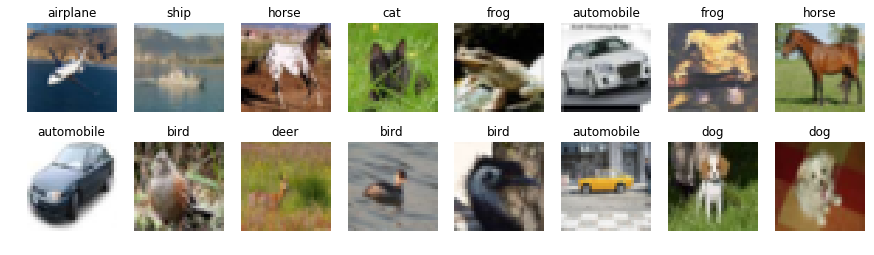

In [87]:
# show random images from train
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 2.5 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_train))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_train[random_index, :])
        ax.set_title(cifar10_classes[y_train[random_index]])
plt.show()

# Prepare data

We need to normalize inputs like this: $$x_{norm} = \frac{x}{255} - 0.5$$

We need to convert class labels to one-hot encoded vectors. Use __keras.utils.to_categorical__.

In [88]:
# normalize inputs
# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
# normalize inputs
x_train2 = x_train/255 - 0.5
x_test2 = x_test/255 - 0.5
x_val2 = x_val/255 - 0.5

# convert class labels to one-hot encoded, should have shape (?, NUM_CLASSES)
y_train2 = keras.utils.to_categorical(y_train)
y_test2 = keras.utils.to_categorical(y_test)
y_val2 = keras.utils.to_categorical(y_val)


# Define CNN architecture

In [89]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from keras.layers.advanced_activations import LeakyReLU

Convolutional networks are built from several types of layers:
- [Conv2D](https://keras.io/layers/convolutional/#conv2d) - performs convolution:
    - **filters**: number of output channels; 
    - **kernel_size**: an integer or tuple/list of 2 integers, specifying the width and height of the 2D convolution window;
    - **padding**: padding="same" adds zero padding to the input, so that the output has the same width and height, padding='valid' performs convolution only in locations where kernel and the input fully overlap;
    - **activation**: "relu", "tanh", etc.
    - **input_shape**: shape of input.
- [MaxPooling2D](https://keras.io/layers/pooling/#maxpooling2d) - performs 2D max pooling.
- [Flatten](https://keras.io/layers/core/#flatten) - flattens the input, does not affect the batch size.
- [Dense](https://keras.io/layers/core/#dense) - fully-connected layer.
- [Activation](https://keras.io/layers/core/#activation) - applies an activation function.
- [LeakyReLU](https://keras.io/layers/advanced-activations/#leakyrelu) - applies leaky relu activation.
- [Dropout](https://keras.io/layers/core/#dropout) - applies dropout.

### First step

Let's create a mini-convolutional network with roughly such architecture:
* Input layer
* 3x3 convolution with 10 filters and ReLU activation
* 3x3 pooling (or set previous convolution stride to 3)
* Dense layer with 100-neurons and ReLU activation
* 10% dropout
* Output dense layer.

You need to define a model which takes __(None, 32, 32, 3)__ input and predicts __(None, 10)__ output with probabilities for all classes. __None__ in shapes stands for batch dimension.

Simple feed-forward networks in Keras can be defined in the following way:

```python
model = Sequential()  # start feed-forward model definition
model.add(Conv2D(..., input_shape=(32, 32, 3)))  # first layer needs to define "input_shape"

...  # here comes a bunch of convolutional, pooling and dropout layers

model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
model.add(Activation("softmax"))  # output probabilities
```


Train it with Adam optimizer with default params.


### Second step (after you've trained it)

* Add batch_norm (with default params) between convolution and pooling

Re-train the network with the same optimizer


In [90]:
x_train.shape

(40000, 32, 32, 3)

In [91]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(10,3, padding="same", input_shape=(32, 32, 3)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D((3,3)))
    
    model.add(Flatten())
    model.add(Dense(1000))
    model.add(LeakyReLU(0.1))
#     model.add(Dropout(0.1))
    model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
    model.add(Activation("softmax"))  # output probabilities
    
    return model

In [92]:
# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 10)        280       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 10)        40        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 10)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 10)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              1001000   
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 1000)              0         
__________

# Train model

Training of your model can take approx. 4-8 minutes per epoch.

During training you should observe the decrease in reported loss on training and validation.

If the loss on training is not decreasing with epochs you should revise your model definition and learning rate.

In [76]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 10

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.9 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), LrHistory(), TQDMNotebookCallback()],
    validation_data=(x_val2, y_val2),
    shuffle=True,
    verbose=0
)

Learning rate: 0.005


Learning rate: 0.005


Learning rate: 0.005


Learning rate: 0.005


Learning rate: 0.005


Learning rate: 0.005


Learning rate: 0.005


Learning rate: 0.005


Learning rate: 0.005


Learning rate: 0.005


In [ ]:
# save weights to file
model.save_weights("weights.h5")

In [ ]:
# load weights from file (can call without model.fit)
model.load_weights("weights.h5")

# Evaluate model

In [ ]:
# make test predictions
y_pred_test = model.predict_proba(x_test)
y_pred_test_classes = np.argmax(y_pred_test, axis=1)
y_pred_test_max_probas = np.max(y_pred_test, axis=1)

In [ ]:
# confusion matrix and accuracy
from sklearn.metrics import confusion_matrix, accuracy_score
plt.figure(figsize=(7, 6))
plt.title('Confusion matrix', fontsize=16)
plt.imshow(confusion_matrix(y_test, y_pred_test_classes))
plt.xticks(np.arange(10), cifar10_classes, rotation=45, fontsize=12)
plt.yticks(np.arange(10), cifar10_classes, fontsize=12)
plt.colorbar()
plt.show()
print("Test accuracy:", accuracy_score(y_test, y_pred_test_classes))

In [ ]:
# inspect preditions
cols = 8
rows = 2
fig = plt.figure(figsize=(2 * cols - 1, 3 * rows - 1))
for i in range(cols):
    for j in range(rows):
        random_index = np.random.randint(0, len(y_test))
        ax = fig.add_subplot(rows, cols, i * rows + j + 1)
        ax.grid('off')
        ax.axis('off')
        ax.imshow(x_test[random_index, :])
        pred_label = cifar10_classes[y_pred_test_classes[random_index]]
        pred_proba = y_pred_test_max_probas[random_index]
        true_label = cifar10_classes[y_test[random_index]]
        ax.set_title("pred: {}\nscore: {:.3}\ntrue: {}".format(
               pred_label, pred_proba, true_label
        ))
plt.show()

# Main: Quest For A Better Network

(please read it at least diagonally)

* The ultimate quest is to create a network that has as high __accuracy__ as you can push it.
* There is a __mini-report__ at the end that you will have to fill in. We recommend reading it first and filling it while you iterate.
 

In [96]:
def make_model():
    """
    Define your model architecture here.
    Returns `Sequential` model.
    """
    model = Sequential()
    model.add(Conv2D(16,3, padding="same", input_shape=(32, 32, 3)))
    model.add(Conv2D(32,3, padding="same", input_shape=(32, 32, 16)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    
    model.add(Conv2D(32,3, padding="same", input_shape=(32, 32, 32)))
    model.add(Conv2D(64,3, padding="same", input_shape=(32, 32, 32)))
    model.add(BatchNormalization())
    model.add(LeakyReLU(0.1))
    model.add(MaxPooling2D())
    model.add(Dropout(0.25))
    
    model.add(Flatten())
    model.add(Dense(256))  # the last layer with neuron for each class
    model.add(LeakyReLU(0.1))
    model.add(Dropout(0.5))
    model.add(Dense(NUM_CLASSES))  # the last layer with neuron for each class
    model.add(Activation("softmax"))  # output probabilities
    
    return model

# describe model
K.clear_session()  # clear default graph
model = make_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
__________

In [97]:
INIT_LR = 5e-3  # initial learning rate
BATCH_SIZE = 32
EPOCHS = 100

K.clear_session()  # clear default graph
# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',  # we train 10-way classification
    optimizer=keras.optimizers.adamax(lr=INIT_LR),  # for SGD
    metrics=['accuracy']  # report accuracy during training
)

# scheduler of learning rate (decay with epochs)
def lr_scheduler(epoch):
    return INIT_LR * 0.99 ** epoch

# callback for printing of actual learning rate used by optimizer
class LrHistory(keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs={}):
        print("Learning rate:", K.get_value(model.optimizer.lr))

# fit model
model.fit(
    x_train2, y_train2,  # prepared data
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[keras.callbacks.LearningRateScheduler(lr_scheduler), LrHistory(), TQDMNotebookCallback()],
    validation_data=(x_val2, y_val2),
    shuffle=True,
    verbose=0
)

Learning rate: 0.005


39968/|/[loss: 3.751, acc: 0.101] 100%|| 39968/40000 [04:44<00:00, 142.51it/s] Learning rate: 0.00495


39968/|/[loss: 2.101, acc: 0.218] 100%|| 39968/40000 [04:23<00:00, 161.88it/s] Learning rate: 0.0049005


39968/|/[loss: 1.911, acc: 0.306] 100%|| 39968/40000 [04:26<00:00, 170.14it/s] Learning rate: 0.00485149


39968/|/[loss: 1.734, acc: 0.374] 100%|| 39968/40000 [04:43<00:00, 167.11it/s] Learning rate: 0.00480298


39968/|/[loss: 1.580, acc: 0.431] 100%|| 39968/40000 [04:15<00:00, 172.91it/s] Learning rate: 0.00475495


39968/|/[loss: 1.478, acc: 0.468] 100%|| 39968/40000 [04:14<00:00, 168.20it/s] Learning rate: 0.0047074


39968/|/[loss: 1.397, acc: 0.501] 100%|| 39968/40000 [04:16<00:00, 144.43it/s] Learning rate: 0.00466033


39968/|/[loss: 1.334, acc: 0.523] 100%|| 39968/40000 [04:24<00:00, 157.46it/s] Learning rate: 0.00461372


39968/|/[loss: 1.270, acc: 0.547] 100%|| 39968/40000 [04:19<00:00, 158.34it/s] Learning rate: 0.00456759


39968/|/[loss: 1.218, acc: 0.569] 100%|| 39968/40000 [04:27<00:00, 168.15it/s] Learning rate: 0.00452191


39968/|/[loss: 1.173, acc: 0.587] 100%|| 39968/40000 [04:11<00:00, 169.73it/s] Learning rate: 0.00447669


39968/|/[loss: 1.134, acc: 0.602] 100%|| 39968/40000 [04:14<00:00, 168.87it/s] Learning rate: 0.00443192


39968/|/[loss: 1.102, acc: 0.610] 100%|| 39968/40000 [04:15<00:00, 171.56it/s] Learning rate: 0.00438761


39968/|/[loss: 1.068, acc: 0.625] 100%|| 39968/40000 [04:07<00:00, 165.19it/s] Learning rate: 0.00434373


39968/|/[loss: 1.038, acc: 0.635] 100%|| 39968/40000 [04:11<00:00, 172.99it/s] Learning rate: 0.00430029


39968/|/[loss: 1.003, acc: 0.646] 100%|| 39968/40000 [04:06<00:00, 174.01it/s] Learning rate: 0.00425729


39968/|/[loss: 0.977, acc: 0.658] 100%|| 39968/40000 [04:12<00:00, 172.84it/s] Learning rate: 0.00421472


39968/|/[loss: 0.955, acc: 0.663] 100%|| 39968/40000 [04:06<00:00, 170.99it/s] Learning rate: 0.00417257


39968/|/[loss: 0.926, acc: 0.677] 100%|| 39968/40000 [04:11<00:00, 176.06it/s] Learning rate: 0.00413084


39968/|/[loss: 0.906, acc: 0.681] 100%|| 39968/40000 [04:15<00:00, 166.74it/s] Learning rate: 0.00408953


39968/|/[loss: 0.886, acc: 0.689] 100%|| 39968/40000 [04:09<00:00, 171.53it/s] Learning rate: 0.00404864


39968/|/[loss: 0.868, acc: 0.696] 100%|| 39968/40000 [04:11<00:00, 168.70it/s] Learning rate: 0.00400815


39968/|/[loss: 0.850, acc: 0.700] 100%|| 39968/40000 [04:06<00:00, 170.79it/s] Learning rate: 0.00396807


39968/|/[loss: 0.838, acc: 0.707] 100%|| 39968/40000 [04:12<00:00, 166.02it/s] Learning rate: 0.00392839


39968/|/[loss: 0.812, acc: 0.716] 100%|| 39968/40000 [04:06<00:00, 163.03it/s] Learning rate: 0.00388911


39968/|/[loss: 0.796, acc: 0.721] 100%|| 39968/40000 [04:11<00:00, 173.31it/s] Learning rate: 0.00385022


39968/|/[loss: 0.785, acc: 0.724] 100%|| 39968/40000 [04:06<00:00, 174.51it/s] Learning rate: 0.00381171


39968/|/[loss: 0.772, acc: 0.731] 100%|| 39968/40000 [04:12<00:00, 166.05it/s] Learning rate: 0.0037736


39968/|/[loss: 0.752, acc: 0.737] 100%|| 39968/40000 [04:05<00:00, 170.15it/s] Learning rate: 0.00373586


39968/|/[loss: 0.746, acc: 0.739] 100%|| 39968/40000 [04:11<00:00, 171.15it/s] Learning rate: 0.0036985


39968/|/[loss: 0.727, acc: 0.746] 100%|| 39968/40000 [04:16<00:00, 175.05it/s] Learning rate: 0.00366152


39968/|/[loss: 0.720, acc: 0.749] 100%|| 39968/40000 [04:10<00:00, 168.72it/s] Learning rate: 0.0036249


39968/|/[loss: 0.704, acc: 0.753] 100%|| 39968/40000 [04:15<00:00, 169.64it/s] Learning rate: 0.00358865


39968/|/[loss: 0.699, acc: 0.754] 100%|| 39968/40000 [04:08<00:00, 173.26it/s] Learning rate: 0.00355277


39968/|/[loss: 0.690, acc: 0.758] 100%|| 39968/40000 [04:23<00:00, 151.16it/s] Learning rate: 0.00351724


39968/|/[loss: 0.678, acc: 0.763] 100%|| 39968/40000 [04:09<00:00, 171.59it/s] Learning rate: 0.00348207


39968/|/[loss: 0.666, acc: 0.765] 100%|| 39968/40000 [04:06<00:00, 170.06it/s] Learning rate: 0.00344725


39968/|/[loss: 0.654, acc: 0.770] 100%|| 39968/40000 [04:12<00:00, 172.48it/s] Learning rate: 0.00341277


39968/|/[loss: 0.647, acc: 0.772] 100%|| 39968/40000 [04:07<00:00, 172.08it/s] Learning rate: 0.00337865


39968/|/[loss: 0.638, acc: 0.774] 100%|| 39968/40000 [04:12<00:00, 169.53it/s] Learning rate: 0.00334486


39968/|/[loss: 0.632, acc: 0.776] 100%|| 39968/40000 [04:07<00:00, 171.49it/s] Learning rate: 0.00331141


39968/|/[loss: 0.627, acc: 0.783] 100%|| 39968/40000 [04:13<00:00, 168.51it/s] Learning rate: 0.0032783


39968/|/[loss: 0.614, acc: 0.785] 100%|| 39968/40000 [04:09<00:00, 171.60it/s] Learning rate: 0.00324551


39968/|/[loss: 0.600, acc: 0.789] 100%|| 39968/40000 [04:13<00:00, 168.61it/s] Learning rate: 0.00321306


39968/|/[loss: 0.600, acc: 0.788] 100%|| 39968/40000 [04:09<00:00, 158.42it/s] Learning rate: 0.00318093


39968/|/[loss: 0.591, acc: 0.792] 100%|| 39968/40000 [04:13<00:00, 169.94it/s] Learning rate: 0.00314912


39968/|/[loss: 0.588, acc: 0.792] 100%|| 39968/40000 [04:07<00:00, 167.68it/s] Learning rate: 0.00311763


39968/|/[loss: 0.577, acc: 0.797] 100%|| 39968/40000 [04:11<00:00, 170.89it/s] Learning rate: 0.00308645


39968/|/[loss: 0.572, acc: 0.799] 100%|| 39968/40000 [04:16<00:00, 169.38it/s] Learning rate: 0.00305559


39968/|/[loss: 0.573, acc: 0.799] 100%|| 39968/40000 [04:09<00:00, 168.34it/s] Learning rate: 0.00302503


39968/|/[loss: 0.560, acc: 0.803] 100%|| 39968/40000 [04:14<00:00, 173.63it/s] Learning rate: 0.00299478


39968/|/[loss: 0.557, acc: 0.804] 100%|| 39968/40000 [04:08<00:00, 168.27it/s] Learning rate: 0.00296483


39968/|/[loss: 0.541, acc: 0.808] 100%|| 39968/40000 [04:12<00:00, 170.13it/s] Learning rate: 0.00293518


Learning rate: 0.00290583


39968/|/[loss: 0.538, acc: 0.811] 100%|| 39968/40000 [04:10<00:00, 167.92it/s] Learning rate: 0.00287677


39968/|/[loss: 0.533, acc: 0.810] 100%|| 39968/40000 [04:06<00:00, 169.59it/s] Learning rate: 0.00284801


39968/|/[loss: 0.536, acc: 0.812] 100%|| 39968/40000 [04:10<00:00, 170.76it/s] Learning rate: 0.00281953


39968/|/[loss: 0.525, acc: 0.817] 100%|| 39968/40000 [04:14<00:00, 174.34it/s] Learning rate: 0.00279133


39968/|/[loss: 0.521, acc: 0.816] 100%|| 39968/40000 [04:09<00:00, 172.91it/s] Learning rate: 0.00276342


39968/|/[loss: 0.512, acc: 0.820] 100%|| 39968/40000 [04:14<00:00, 171.26it/s] Learning rate: 0.00273578


39968/|/[loss: 0.507, acc: 0.821] 100%|| 39968/40000 [04:09<00:00, 147.85it/s] Learning rate: 0.00270843


39968/|/[loss: 0.501, acc: 0.824] 100%|| 39968/40000 [04:12<00:00, 172.95it/s] Learning rate: 0.00268134


39968/|/[loss: 0.494, acc: 0.826] 100%|| 39968/40000 [04:17<00:00, 154.96it/s] Learning rate: 0.00265453


39968/|/[loss: 0.492, acc: 0.827] 100%|| 39968/40000 [04:15<00:00, 173.28it/s] Learning rate: 0.00262798


39968/|/[loss: 0.494, acc: 0.826] 100%|| 39968/40000 [04:04<00:00, 167.96it/s] Learning rate: 0.0026017


39968/|/[loss: 0.485, acc: 0.828] 100%|| 39968/40000 [04:10<00:00, 171.84it/s] Learning rate: 0.00257569


39968/|/[loss: 0.482, acc: 0.829] 100%|| 39968/40000 [04:06<00:00, 166.14it/s] Learning rate: 0.00254993


39968/|/[loss: 0.477, acc: 0.834] 100%|| 39968/40000 [04:11<00:00, 172.47it/s] Learning rate: 0.00252443


39968/|/[loss: 0.481, acc: 0.831] 100%|| 39968/40000 [04:07<00:00, 173.15it/s] Learning rate: 0.00249919


39968/|/[loss: 0.482, acc: 0.831] 100%|| 39968/40000 [04:13<00:00, 168.66it/s] Learning rate: 0.00247419


39968/|/[loss: 0.469, acc: 0.835] 100%|| 39968/40000 [04:09<00:00, 170.31it/s] Learning rate: 0.00244945


39968/|/[loss: 0.471, acc: 0.834] 100%|| 39968/40000 [04:13<00:00, 169.22it/s] Learning rate: 0.00242496


39968/|/[loss: 0.461, acc: 0.836] 100%|| 39968/40000 [04:08<00:00, 166.90it/s] Learning rate: 0.00240071


39968/|/[loss: 0.457, acc: 0.840] 100%|| 39968/40000 [04:13<00:00, 150.75it/s] Learning rate: 0.0023767


39968/|/[loss: 0.455, acc: 0.839] 100%|| 39968/40000 [04:08<00:00, 173.39it/s] Learning rate: 0.00235293


39968/|/[loss: 0.449, acc: 0.840] 100%|| 39968/40000 [04:12<00:00, 169.79it/s] Learning rate: 0.0023294


39968/|/[loss: 0.455, acc: 0.842] 100%|| 39968/40000 [04:07<00:00, 172.01it/s] Learning rate: 0.00230611


39968/|/[loss: 0.447, acc: 0.841] 100%|| 39968/40000 [04:10<00:00, 174.13it/s] Learning rate: 0.00228305


39968/|/[loss: 0.448, acc: 0.842] 100%|| 39968/40000 [04:14<00:00, 167.98it/s] Learning rate: 0.00226022


39968/|/[loss: 0.441, acc: 0.843] 100%|| 39968/40000 [04:09<00:00, 172.10it/s] Learning rate: 0.00223762


39968/|/[loss: 0.437, acc: 0.845] 100%|| 39968/40000 [04:04<00:00, 172.35it/s] Learning rate: 0.00221524


39968/|/[loss: 0.434, acc: 0.846] 100%|| 39968/40000 [04:10<00:00, 171.25it/s] Learning rate: 0.00219309


39968/|/[loss: 0.437, acc: 0.846] 100%|| 39968/40000 [04:16<00:00, 170.98it/s] Learning rate: 0.00217116


39968/|/[loss: 0.430, acc: 0.848] 100%|| 39968/40000 [04:09<00:00, 166.27it/s] Learning rate: 0.00214945


39968/|/[loss: 0.428, acc: 0.846] 100%|| 39968/40000 [04:13<00:00, 172.35it/s] Learning rate: 0.00212795


39968/|/[loss: 0.422, acc: 0.851] 100%|| 39968/40000 [04:06<00:00, 169.46it/s] Learning rate: 0.00210667


39968/|/[loss: 0.424, acc: 0.851] 100%|| 39968/40000 [04:11<00:00, 159.01it/s] Learning rate: 0.0020856


39968/|/[loss: 0.419, acc: 0.852] 100%|| 39968/40000 [04:14<00:00, 167.46it/s] Learning rate: 0.00206475


39968/|/[loss: 0.417, acc: 0.855] 100%|| 39968/40000 [04:08<00:00, 167.33it/s] Learning rate: 0.0020441


39968/|/[loss: 0.416, acc: 0.854] 100%|| 39968/40000 [04:10<00:00, 168.64it/s] Learning rate: 0.00202366


39968/|/[loss: 0.416, acc: 0.853] 100%|| 39968/40000 [04:10<00:00, 157.68it/s] Learning rate: 0.00200342


39968/|/[loss: 0.406, acc: 0.855] 100%|| 39968/40000 [04:21<00:00, 171.27it/s] Learning rate: 0.00198339


39968/|/[loss: 0.407, acc: 0.857] 100%|| 39968/40000 [04:08<00:00, 168.51it/s] Learning rate: 0.00196356


39968/|/[loss: 0.409, acc: 0.856] 100%|| 39968/40000 [04:12<00:00, 147.43it/s] Learning rate: 0.00194392


39968/|/[loss: 0.398, acc: 0.860] 100%|| 39968/40000 [04:06<00:00, 172.07it/s] Learning rate: 0.00192448


39968/|/[loss: 0.397, acc: 0.858] 100%|| 39968/40000 [04:11<00:00, 169.72it/s] Learning rate: 0.00190524


39968/|/[loss: 0.395, acc: 0.862] 100%|| 39968/40000 [04:21<00:00, 113.83it/s] Learning rate: 0.00188618


39968/|/[loss: 0.391, acc: 0.859] 100%|| 39968/40000 [04:51<00:00, 163.71it/s] Learning rate: 0.00186732


39968/|/[loss: 0.396, acc: 0.861] 100%|| 39968/40000 [05:42<00:00, 109.12it/s] Learning rate: 0.00184865


39968/|/[loss: 0.395, acc: 0.862] 100%|| 39968/40000 [06:45<00:00, 101.61it/s] 

### Hi, my name is Alexander Ageev`, and here's my story

A long ago in a galaxy far far away, when it was still more than an hour before deadline, i got an idea:

##### I gonna build a convolutional neural network with one conv. layer with ReLu activation

How could i be so naive?!

##### One day, with no signs of warning,
This thing has finally converged but the accuracy of prediction was too low.

##### Finally, after 100  epochs, 2 mugs of tea and coffee
Model with this architecture
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
conv2d_1 (Conv2D)            (None, 32, 32, 16)        448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 32, 32, 32)        4640      
_________________________________________________________________
batch_normalization_1 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 32, 32, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 16, 16, 32)        9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 16, 16, 64)        256       
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 16, 16, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 8, 8, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4096)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               1048832   
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0  

That, having wasted 7 hours 14 minutes 39 seconds of my life training, got accuracy on validation: 0.862.

The architecture was borrowed from Coursera's course 'Intro to DL'

## Grading
* starting at zero points
* +2 for describing your iteration path in a report below.
* +2 for building a network that gets above 20% accuracy
* +1 for beating each of these milestones on __TEST__ dataset:
    * 50% (5 total)
    * 60% (6 total)
    * 65% (7 total)
    * 70% (8 total)
    * 75% (9 total)
    * 80% (10 total)
    
## Bonus points

Common ways to get bonus points are:
* Get higher score, obviously.
* Anything special about your NN. For example "A super-small/fast NN that gets 80%" gets a bonus.
* Any detailed analysis of the results. (saliency maps, whatever)

## Restrictions
* Please do NOT use pre-trained networks for this assignment until you reach 80%.
 * In other words, base milestones must be beaten without pre-trained nets (and such net must be present in the e-mail). After that, you can use whatever you want.
* you __can__ use validation data for training, but you __can't'__ do anything with test data apart from running the evaluation procedure.

## Tips on what can be done:


 * __Network size__
   * MOAR neurons, 
   * MOAR layers, ([lasagne docs](http://lasagne.readthedocs.org))

   * Nonlinearities in the hidden layers
     * tanh, relu, leaky relu, etc
   * Larger networks may take more epochs to train, so don't discard your net just because it could didn't beat the baseline in 5 epochs.

   * Ph'nglui mglw'nafh Cthulhu R'lyeh wgah'nagl fhtagn!

 * __Convolution layers__
   * they __are a must__ unless you have any super-ideas
   * `network = lasagne.layers.Conv2DLayer(prev_layer,`
    `                        num_filters = n_neurons,`
    `                        filter_size = (filter width, filter height),`
    `                        nonlinearity = some_nonlinearity)`
   * Warning! Training convolutional networks can take long without GPU. That's okay.
     * If you are CPU-only, we still recomment to try a simple convolutional architecture
     * a perfect option is if you can set it up to run at nighttime and check it up at the morning.
     * Make reasonable layer size estimates. A 128-neuron first convolution is likely an overkill.
     * __To reduce computation__ time by a factor in exchange for some accuracy drop, try using __stride__ parameter. A stride=2 convolution should take roughly 1/4 of the default (stride=1) one.
 
   * Plenty other layers and architectures
     * http://lasagne.readthedocs.org/en/latest/modules/layers.html
     * batch normalization, pooling, etc

 * __Early Stopping__
   * Training for 100 epochs regardless of anything is probably a bad idea.
   * Some networks converge over 5 epochs, others - over 500.
   * Way to go: stop when validation score is 10 iterations past maximum
     

 * __Faster optimization__ - 
   * rmsprop, nesterov_momentum, adam, adagrad and so on.
     * Converge faster and sometimes reach better optima
     * It might make sense to tweak learning rate/momentum, other learning parameters, batch size and number of epochs
   * __BatchNormalization__ (lasagne.layers.batch_norm) FTW!


 * __Regularize__ to prevent overfitting
   * Add some L2 weight norm to the loss function, theano will do the rest
     * Can be done manually or via - http://lasagne.readthedocs.org/en/latest/modules/regularization.html
   * Dropout - to prevent overfitting
     * `lasagne.layers.DropoutLayer(prev_layer, p=probability_to_zero_out)`   
     * Don't overdo it. Check if it actually makes your network better
   
   
 * __Data augmemntation__ - getting 5x as large dataset for free is a great deal
   * Zoom-in+slice = move
   * Rotate+zoom(to remove black stripes)
   * any other perturbations
   * Add Noize (easiest: GaussianNoizeLayer)
   * Simple way to do that (if you have PIL/Image): 
     * ```from scipy.misc import imrotate,imresize```
     * and a few slicing
   * Stay realistic. There's usually no point in flipping dogs upside down as that is not the way you usually see them.
   
   
   
   
   
 
 
   
There is a template for your solution below that you can opt to use or throw away and write it your way